In [1]:
from models.modules import Discriminator, Generator, Trainer

import matplotlib.pyplot as plt

import torch as t
from torch import nn
from torch.nn import functional as f
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data = MNIST(root='./data', train=True, transform=transform, download=True)

In [11]:
discriminator = Discriminator(dropout_rate=0.2)
generator = Generator(dropout_rate=0.1)

d_learning_rate = 5e-5
g_learning_rate = 1e-4
epochs = 300

criterion = nn.CrossEntropyLoss()

discriminator_optimizer = t.optim.Adam(discriminator.parameters(), lr=d_learning_rate)
generator_optimizer = t.optim.Adam(generator.parameters(), lr=g_learning_rate)

discriminator_scheduler = t.optim.lr_scheduler.CosineAnnealingLR(discriminator_optimizer, T_max=epochs, eta_min=1e-6)
generator_scheduler = t.optim.lr_scheduler.CosineAnnealingLR(generator_optimizer, T_max=epochs, eta_min=1e-5)

trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    train=data,
    criterion=criterion,
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    d_scheduler=discriminator_scheduler,
    g_scheduler=generator_scheduler,
    batch_size=256,
    num_epochs=epochs
)

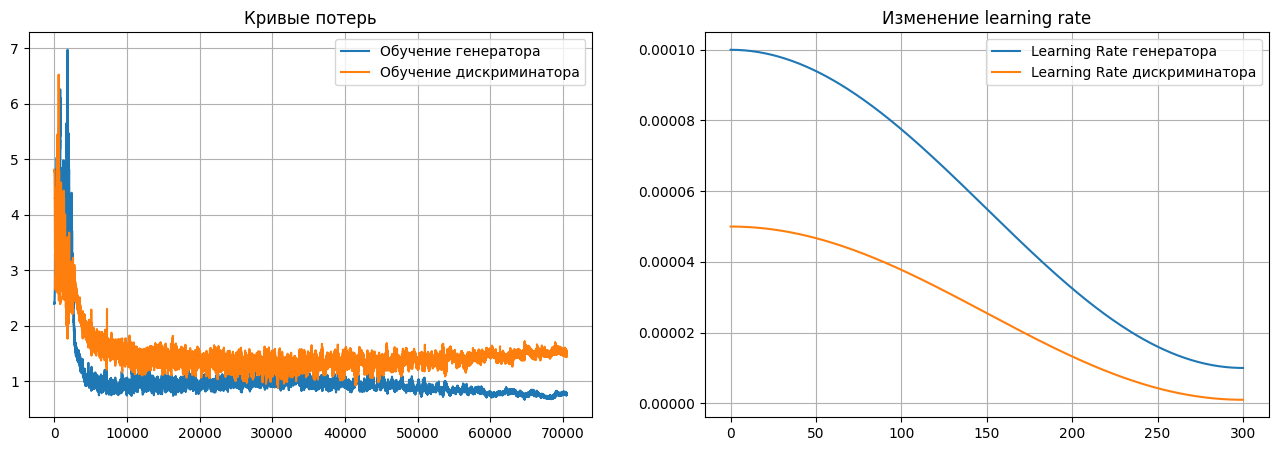

In [119]:
trainer.train(visualize=True)

In [273]:
def generate_image(numbers):
    onehot = f.one_hot(numbers, num_classes=10)
    random_noise = t.randn(numbers.shape[0], 246)
    request = t.cat([onehot, random_noise], dim=-1)

    generator.eval()
    with t.no_grad():
        images = generator(request)

    return images

nums = t.arange(10)
generated_images = 1 - generate_image(nums).squeeze()

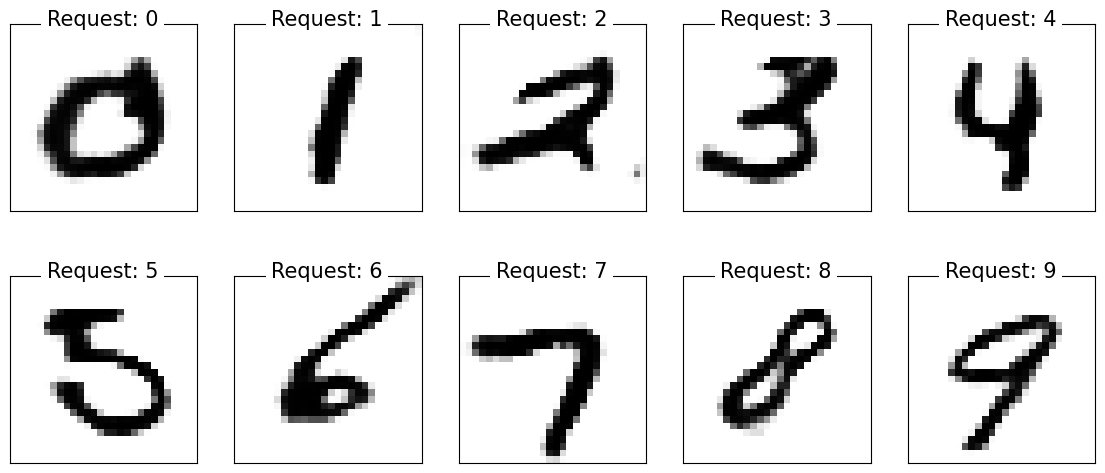

In [274]:
plt.figure(figsize=(14, 6))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    plt.imshow(generated_images[i, :, :], cmap='grey')
    plt.text(5, -0.25, f'Request: {nums[i]}', bbox={'facecolor': 'white', 'edgecolor':'none'}, fontsize=15)
    plt.xticks([]); plt.yticks([])

In [269]:
# Сохраним параметры модели
checkpoint = {
    'Generator': generator.state_dict(),
    'Discriminator': discriminator.state_dict()
}

t.save(checkpoint, 'models/models.pth')